## Trains a baseline U-Net

In [1]:
# Name data and config types
DATASET_NAME = "data0" # name of the npz file
CFG_NAME = "unet2" # name of the architecture/configuration

In [2]:
# Import libraries

import os
import matplotlib.pyplot as plt

%matplotlib inline
import numpy as np
import time
from tqdm import tqdm
from keras.callbacks import ModelCheckpoint, CSVLogger, EarlyStopping, ReduceLROnPlateau
from keras import callbacks
from keras import backend as K
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import jaccard_similarity_score

# Go back one step to read module
import sys
sys.path.insert(0,"..") 

import data_utils
import classes
import models as M
import losses as l

ROOT_DIR = os.path.abspath("../")
DATASET_FOLDER = "npy_data"
DATASET_PATH = os.path.join(ROOT_DIR, "datasets", DATASET_FOLDER)
EXPERIMENT_NAME = "{}_{}".format(DATASET_NAME, CFG_NAME)



batch_size = 16
epochs = 100000
interval = 10 #show correct dice and log it after every ? epochs


if not os.path.exists(os.path.join(ROOT_DIR, "logs")):
    os.mkdir(os.path.join(ROOT_DIR, "logs"))

# Make log path to store all results
LOG_PATH = os.path.join(ROOT_DIR, "logs", EXPERIMENT_NAME)

if not os.path.exists(LOG_PATH):
    os.mkdir(LOG_PATH)
    
print(os.listdir(DATASET_PATH))


# Load the dataset
data = np.load(DATASET_PATH + '/{}.npz'.format(DATASET_NAME))
train_data = data['name1']
train_labels = data['name2']
train_data = np.expand_dims(train_data, axis=-1)
train_labels = np.minimum(train_labels, 1)
train_labels = np.expand_dims(train_labels, axis=-1)
print(train_data.shape, train_labels.shape)

Using TensorFlow backend.


['test_mask.npy', 'data1.npz', 'test_img.npy', 'data0.npz', 'data2.npz']
(3644, 256, 256, 1) (3644, 256, 256, 1)


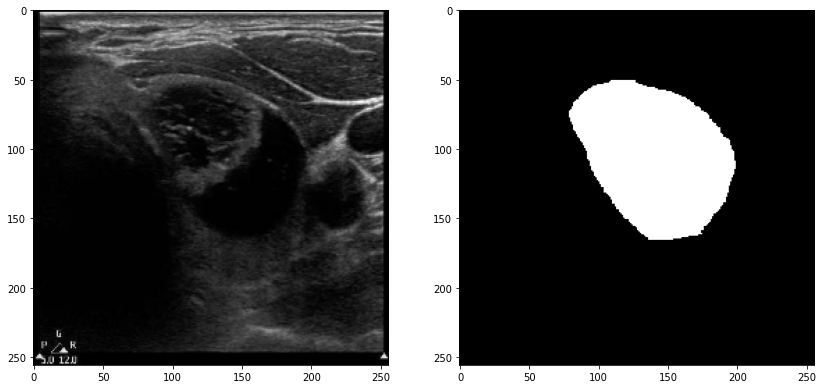

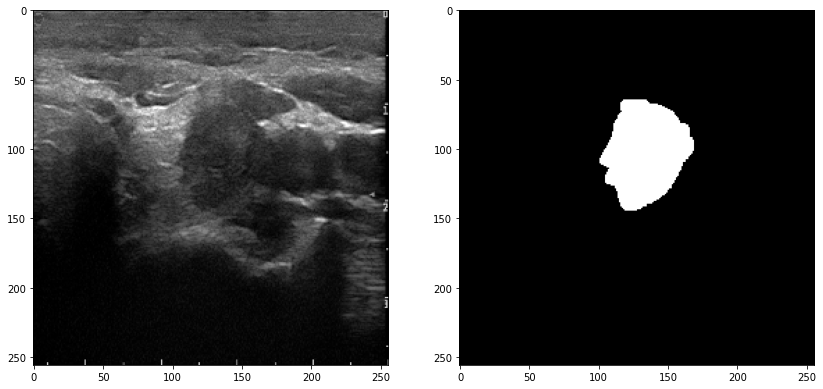

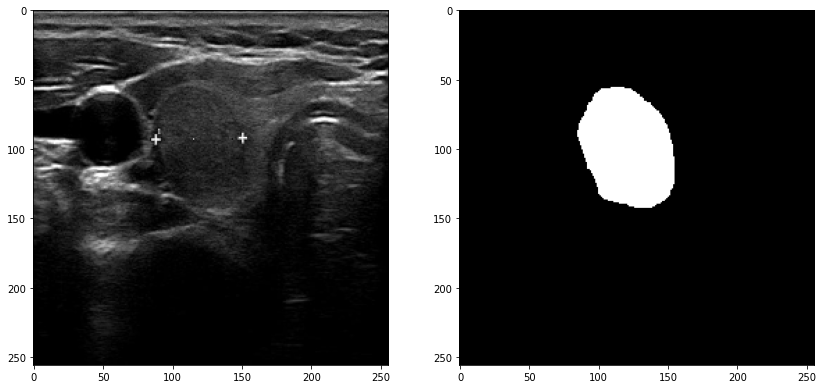

In [3]:
for img, mask in zip(train_data[:3], train_labels[:3]):
    
    img = np.squeeze(img, axis=-1) # change to H, W
    mask = np.squeeze(mask, axis=-1) # change to H, W
    
    
    fig,_ = plt.subplots(nrows=1, ncols=2, figsize=(14,12))
    fig.axes[0].imshow(img, cmap='gray')
    fig.axes[1].imshow(mask, cmap='gray')
    plt.show()

In [4]:
# Plot and save accuravy loss graphs individually
def plot_graphs(history):
    
    # b, g, r, y, o, -g, -m
    
    experiment_name = EXPERIMENT_NAME
    plt.figure(figsize=(18, 5))
    plt.subplot(131)
    plt.plot(history.history['loss'],linewidth=4)
    plt.plot(history.history['val_loss'],linewidth=4)
    plt.title('{} loss'.format(experiment_name))
    #plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.grid(True)

    

    plt.subplot(132)
    plt.plot(history.history['jacard'],linewidth=4)
    plt.plot(history.history['val_jacard'],linewidth=4)
    plt.title('{} Jacard'.format(experiment_name))
    #plt.ylabel('Jacard')
    plt.xlabel('Epoch')
    plt.grid(True)
    plt.legend(['Train', 'Test'], loc='upper left')



    plt.subplot(133)
    plt.plot(history.history['dice_coef'],linewidth=4)
    plt.plot(history.history['val_dice_coef'],linewidth=4)
    plt.title('{} Dice'.format(experiment_name))
    #plt.ylabel('Dice')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.grid(True)
    plt.savefig('{}/{}_graph.png'.format(LOG_PATH, EXPERIMENT_NAME), dpi=100)
    plt.show()

In [5]:
# Build standard U-Net model
model = M.unet(input_size = (train_data.shape[1], train_data.shape[2], train_data.shape[-1]))

# Build U-Net model with custom encoder
#backbone_name = 'vgg16'
#encoder_weights = None
#model = M.unet_backbone(backbone=backbone_name, input_size = (train_data.shape[1], 
#            train_data.shape[2], train_data.shape[-1]), encoder_weights=encoder_weights)

model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 256, 1)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 32) 320         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 256, 256, 32) 9248        conv2d_1[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 128, 128, 32) 0           conv2d_2[0][0]                   
____________________________________________________________________________________________

## Split data and train

In [6]:
# Split into training and validation sets
x_train = train_data[:2915]
x_test = train_data[2915:]
y_train = train_labels[:2915]
y_test = train_labels[2915:]
print("Train and validate on -------> ", x_train.shape, x_test.shape, y_train.shape, y_test.shape)

Train and validate on ------->  (2915, 256, 256, 1) (729, 256, 256, 1) (2915, 256, 256, 1) (729, 256, 256, 1)


## Callbacks

In [7]:
# Callbacks
weights_path = "{}/{}.h5".format(LOG_PATH, EXPERIMENT_NAME)
checkpointer = ModelCheckpoint(filepath=weights_path, verbose=1, monitor='val_jacard', mode='max', save_best_only=True)
reduce_lr = ReduceLROnPlateau(monitor='val_jacard', factor=0.1, patience=5, verbose=1, min_lr=1e-8, mode='max') # new_lr = lr * factor
early_stopping = EarlyStopping(monitor='val_jacard', min_delta=0, verbose=1, patience=8, mode='max', restore_best_weights=True)
csv_logger = CSVLogger('{}/{}_training.csv'.format(LOG_PATH, EXPERIMENT_NAME))

ie = classes.IntervalEvaluation(EXPERIMENT_NAME, LOG_PATH, interval, validation_data=(x_test, y_test),
                                training_data=(x_train, y_train))

In [8]:
# Train
model.fit(x_train, y_train,
                batch_size=batch_size,
                epochs=epochs,
                validation_data=(x_test, y_test),
                callbacks=[ie, checkpointer, reduce_lr, csv_logger, early_stopping],
                shuffle=True)

Train on 2915 samples, validate on 729 samples
Epoch 1/100000
2915/2915 [==============================] - 31s 11ms/step - loss: 0.3382 - jacard: 0.0612 - dice_coef: 0.1145 - val_loss: 0.2191 - val_jacard: 0.1000 - val_dice_coef: 0.1814

Training Operating Point:0.5000, Accuracy :0.9084, Sensitivity:0.0000, Specificity: 1.0000, Dice: 0.0000
Validation Operating Point:0.5000, Accuracy :0.9199, Sensitivity:0.0000, Specificity: 1.0000, Dice: 0.0000


Epoch 00001: val_jacard improved from -inf to 0.09996, saving model to /home/hasib/hasib/thyroid-nodule-sc/logs/data0_unet2/data0_unet2.h5
Epoch 2/100000
2915/2915 [==============================] - 27s 9ms/step - loss: 0.1997 - jacard: 0.2150 - dice_coef: 0.3494 - val_loss: 0.1634 - val_jacard: 0.2238 - val_dice_coef: 0.3641

Epoch 00002: val_jacard improved from 0.09996 to 0.22379, saving model to /home/hasib/hasib/thyroid-nodule-sc/logs/data0_unet2/data0_unet2.h5
Epoch 3/100000
2915/2915 [==============================] - 27s 9ms/step - lo

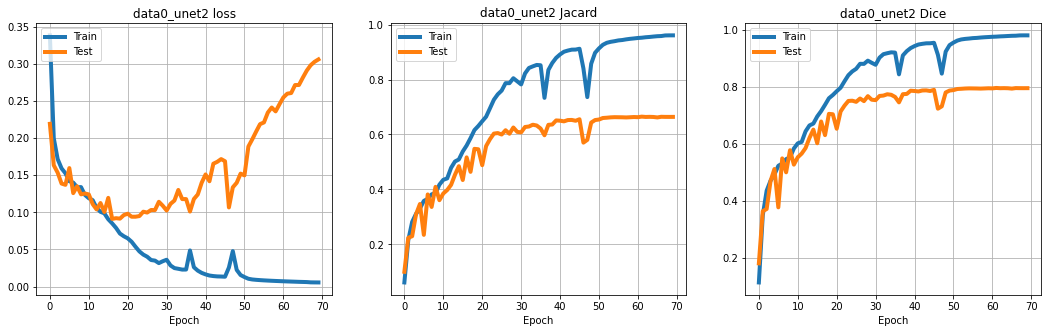

In [9]:
# Log training history
plot_graphs(model.history)

In [10]:
# Evaluate trained model using Jaccard and Dice metric
from tensorflow.keras.models import load_model
model = None
model = load_model(weights_path, compile=False)
yp = model.predict(x=x_test, batch_size=16, verbose=1)
#Round off boolean masks
yp = np.round(yp,0)
yp.shape

729/729 [==============================] - 2s 3ms/sample


(729, 256, 256, 1)

In [11]:
y_test.shape, yp.shape

((729, 256, 256, 1), (729, 256, 256, 1))

In [12]:
# Eval on train set
yp_t = None
yp_t = model.predict(x=x_train, batch_size=16, verbose=0)
#Round off boolean masks
yp_t = np.round(yp_t,0)
yp_t.shape

(2915, 256, 256, 1)

In [13]:
yp_t.shape, yp.shape

((2915, 256, 256, 1), (729, 256, 256, 1))

In [14]:
y_train.shape, y_test.shape

((2915, 256, 256, 1), (729, 256, 256, 1))

In [15]:
np.savez('{}/{}_{}_mask_pred.npz'.format(LOG_PATH, CFG_NAME, DATASET_NAME), 
         name1=y_train, name2=y_test, name3=yp_t, name4=yp)

In [16]:
# # binary segmentation

# try:
#     os.makedirs('{}/results/'.format(LOG_PATH, EXPERIMENT_NAME))
# except:
#     pass 

# for i in range(5):
    
#     plt.figure(figsize=(20,10))
#     plt.subplot(1,3,1)
#     if len(x_test[i].shape) >= 2:
#         plt.grid(False)
#         plt.imshow(x_test[i].squeeze(), cmap='gray') # 1-channel image
#     else:
#         plt.grid(False)
#         plt.imshow(x_test[i]) # 3-channel
        
#     plt.title('Input')
#     plt.subplot(1,3,2)
#     plt.grid(False)
#     plt.imshow(y_test[i].reshape(y_test[i].shape[0],y_test[i].shape[1]), cmap='magma') #cmap='magma'
#     plt.title('Ground Truth')
#     plt.subplot(1,3,3)
#     plt.grid(False)
#     plt.imshow(yp[i].reshape(yp[i].shape[0],yp[i].shape[1]),cmap='magma')
#     plt.title('Prediction')
    
#     # Calc jaccard index of predictions
#     intersection = yp[i].ravel() * y_test[i].ravel()
#     union = yp[i].ravel() + y_test[i].ravel() - intersection
#     jacard = (np.sum(intersection)/np.sum(union))  
    
#     plt.suptitle('Jacard Index: '+ str(np.sum(intersection)) +'/'+ str(np.sum(union)) +' = '+str(jacard))
#     plt.savefig('{}/results/'.format(LOG_PATH, EXPERIMENT_NAME)+str(i)+'.png',format='png')
#     plt.show()
#     plt.close()